In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
from helper import points_extraction, corners_unwarp, abs_sobel_thresh, mag_thresh, dir_threshold, hls_select
from helper import hist, find_lane_pixels, fit_polynomial, fit_poly, search_around_poly, measure_curvature_pixels
from helper import measure_curvature_real, region_of_interest

# Camera Calibration and Distortion Correction Steps

In [3]:
# make list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

(objpoints, imgpoints, retlist) = points_extraction(images, nx=9, ny=6)

Text(0.5,1,'Undistorted Image')

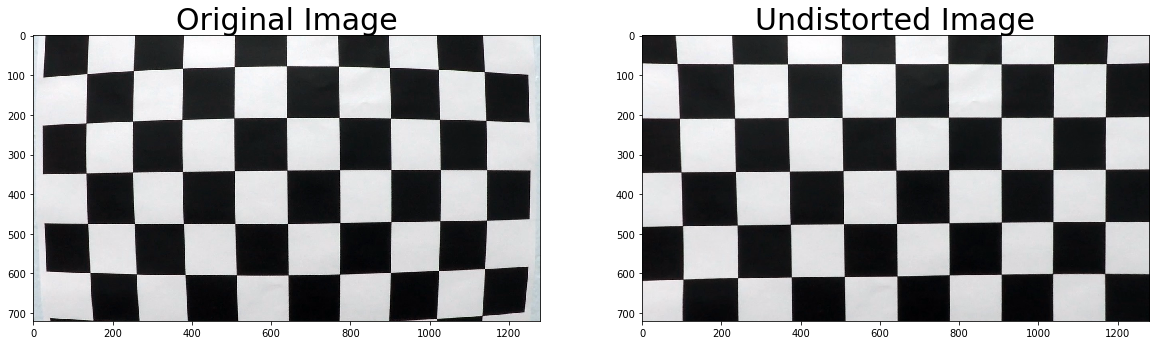

In [4]:
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# h_thresh=(19, 90), sx_thresh=(15, 110), r_thresh=(215, 255)

def color_gradient_pipline(img, h_thresh=(19, 90), sx_thresh=(15, 110), r_thresh=(225, 255)):
    img = np.copy(img)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    img = np.copy(undist)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    h_channel = hls[:,:,0]
    #l_channel = hls[:,:,1]
    # s_channel = hls[:,:,2]

    # h_thresh = (19, 90)
    h_binary_output = np.zeros_like(h_channel)
    h_binary_output[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1

    # R threshold
    R = image[:,:,2]
    # r_thresh = (215, 255)
    r_binary = np.zeros_like(R)
    r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1

    # Sobel x
    # sx_thresh = (15, 110)
    r_sx_binary = abs_sobel_thresh(R, orient='x', sobel_kernel=5, sob_thresh=sx_thresh)


    # Combine the two binary thresholds
    combined_binary = np.zeros_like(h_binary_output)
    combined_binary[(h_binary_output == 1) | (r_sx_binary == 1) | (r_binary == 1)] = 1
    
    return combined_binary, h_binary_output, r_binary, r_sx_binary

In [6]:
def show_color_gradient_pipline(img):
    combined_binary, h_binary_output, r_binary, r_sx_binary = color_gradient_pipline(image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(h_binary_output, cmap='gray')
    ax1.set_title('h_binary_output', fontsize=40)

    ax2.imshow(r_binary, cmap='gray')
    ax2.set_title('r_binary', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(r_sx_binary, cmap='gray')
    ax1.set_title('r_sx_binary', fontsize=40)

    ax2.imshow(combined_binary, cmap='gray')
    ax2.set_title('combined_binary', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

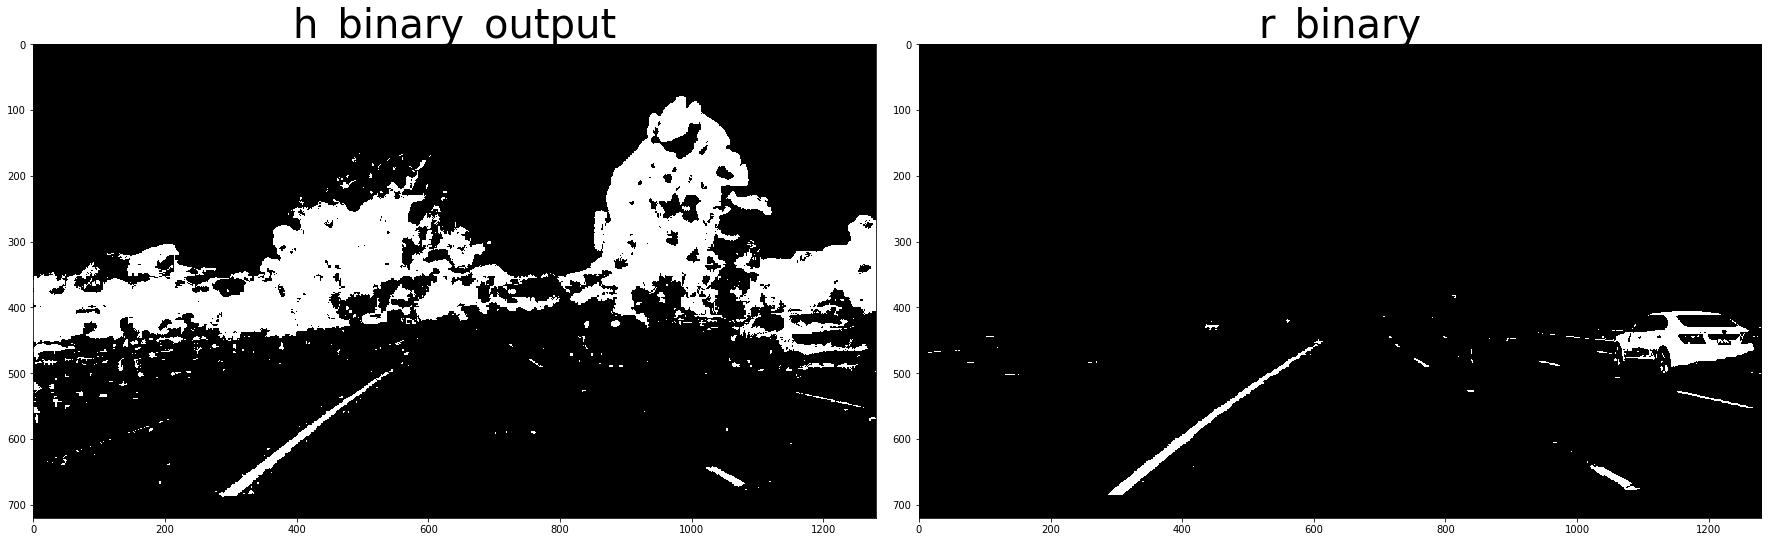

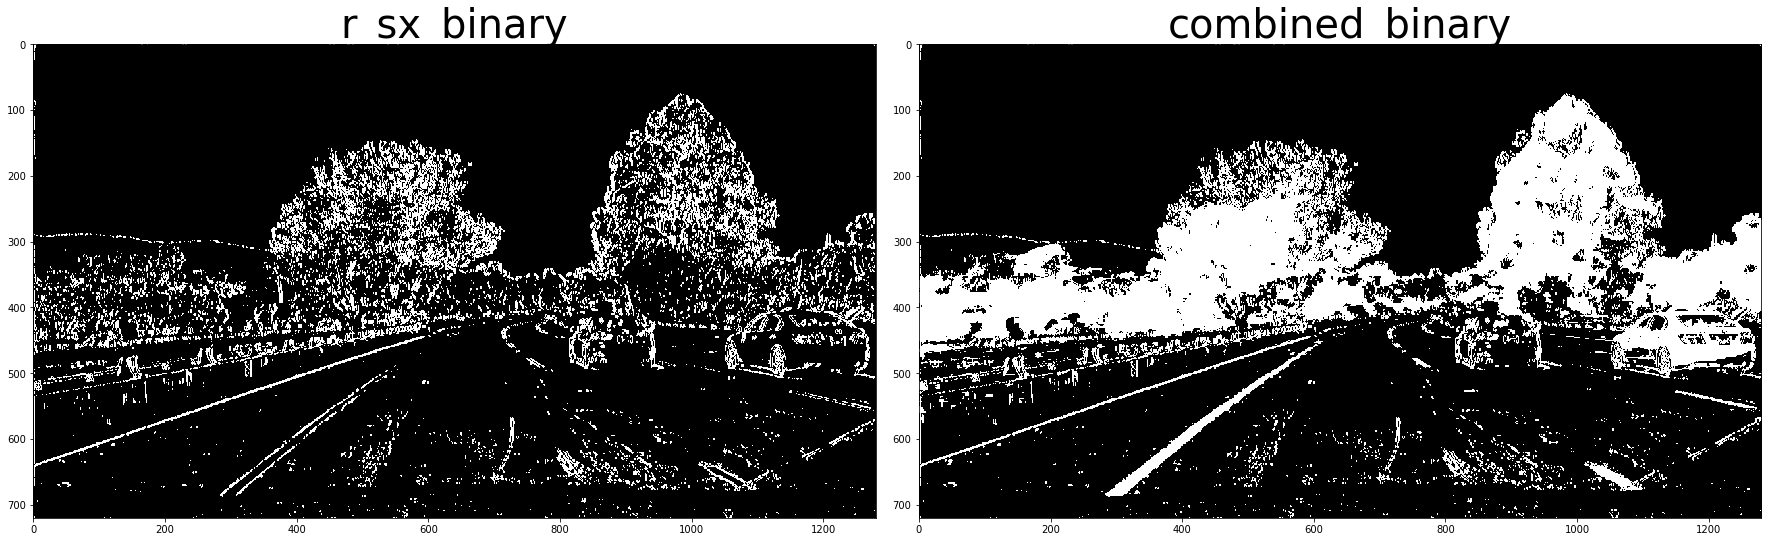

In [7]:
image = cv2.imread('test_images/test1.jpg')

show_color_gradient_pipline(image)

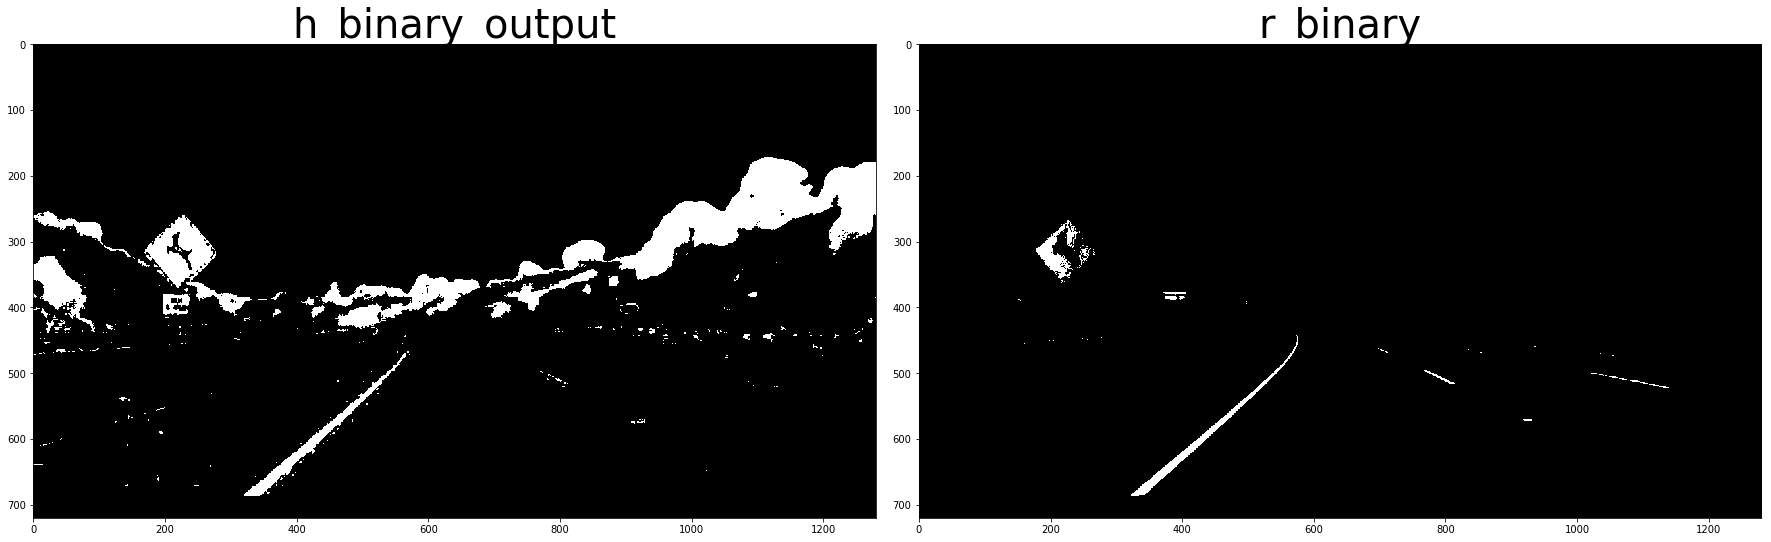

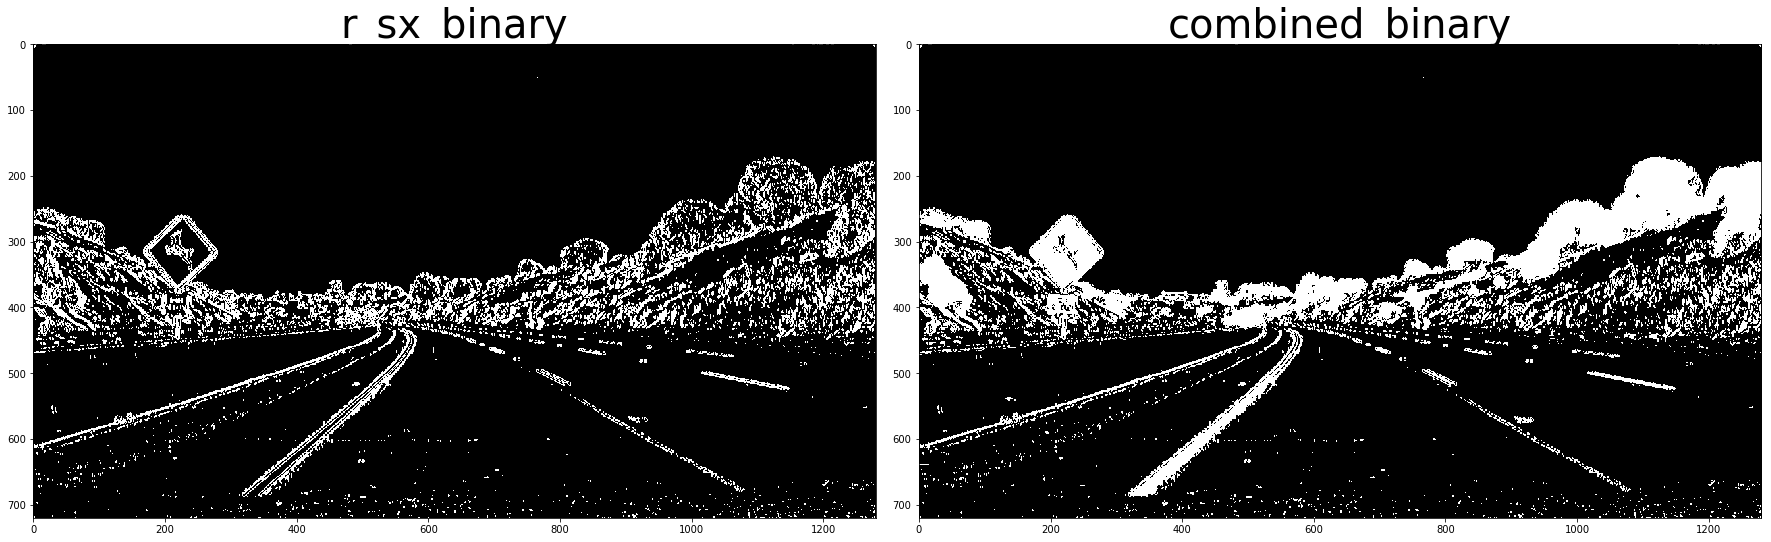

In [8]:
image = cv2.imread('test_images/test2.jpg')

show_color_gradient_pipline(image)

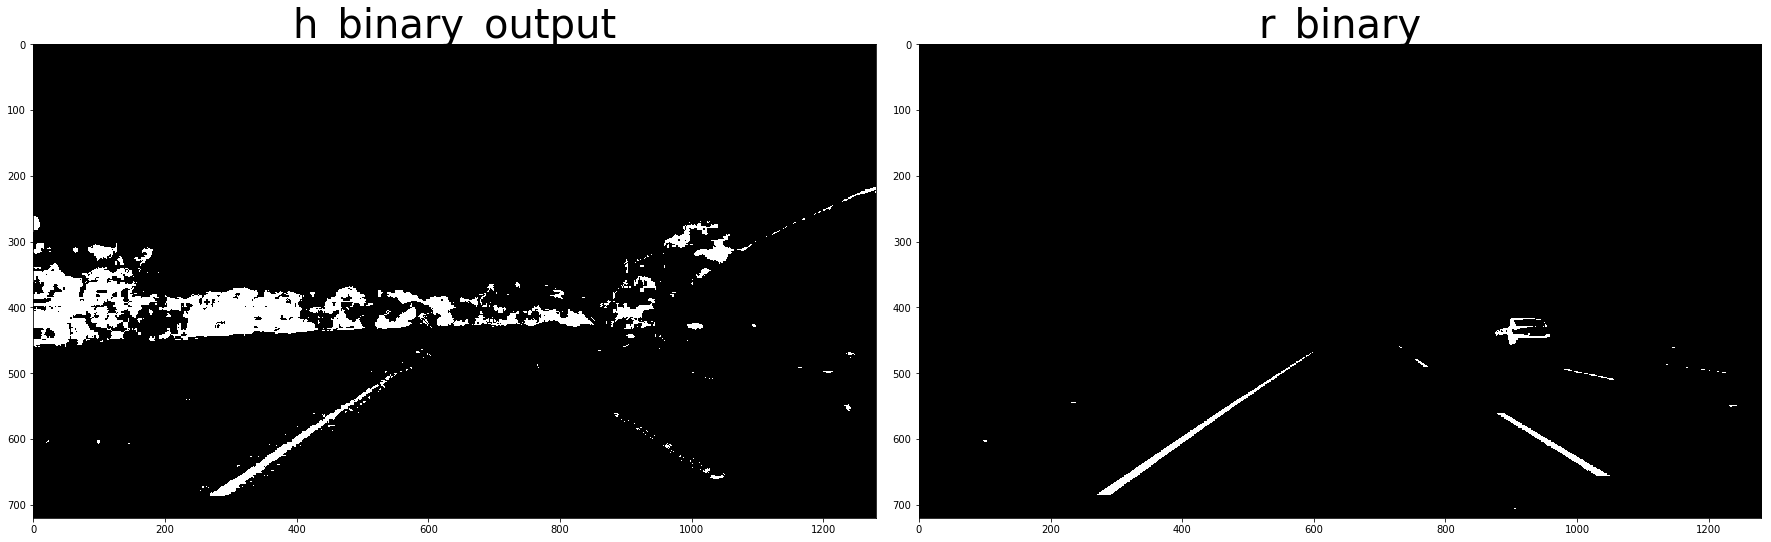

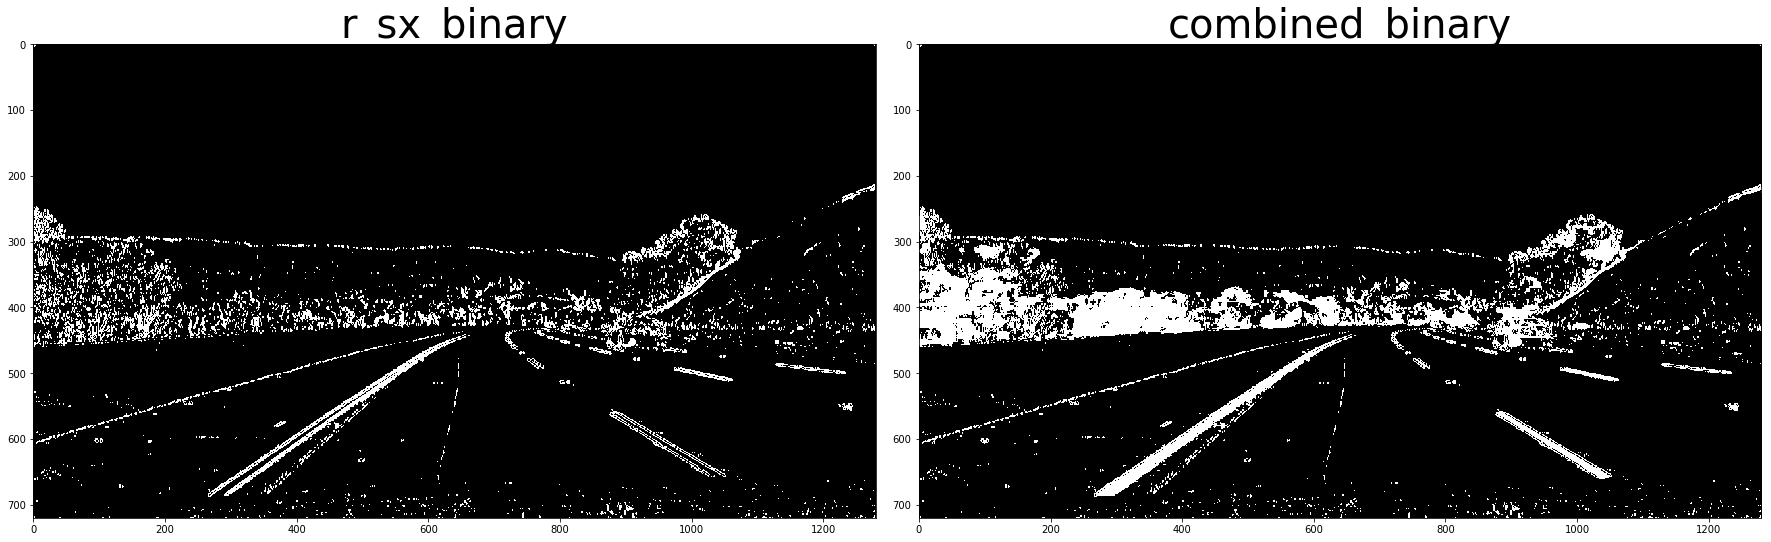

In [9]:
image = cv2.imread('test_images/test3.jpg')

show_color_gradient_pipline(image)

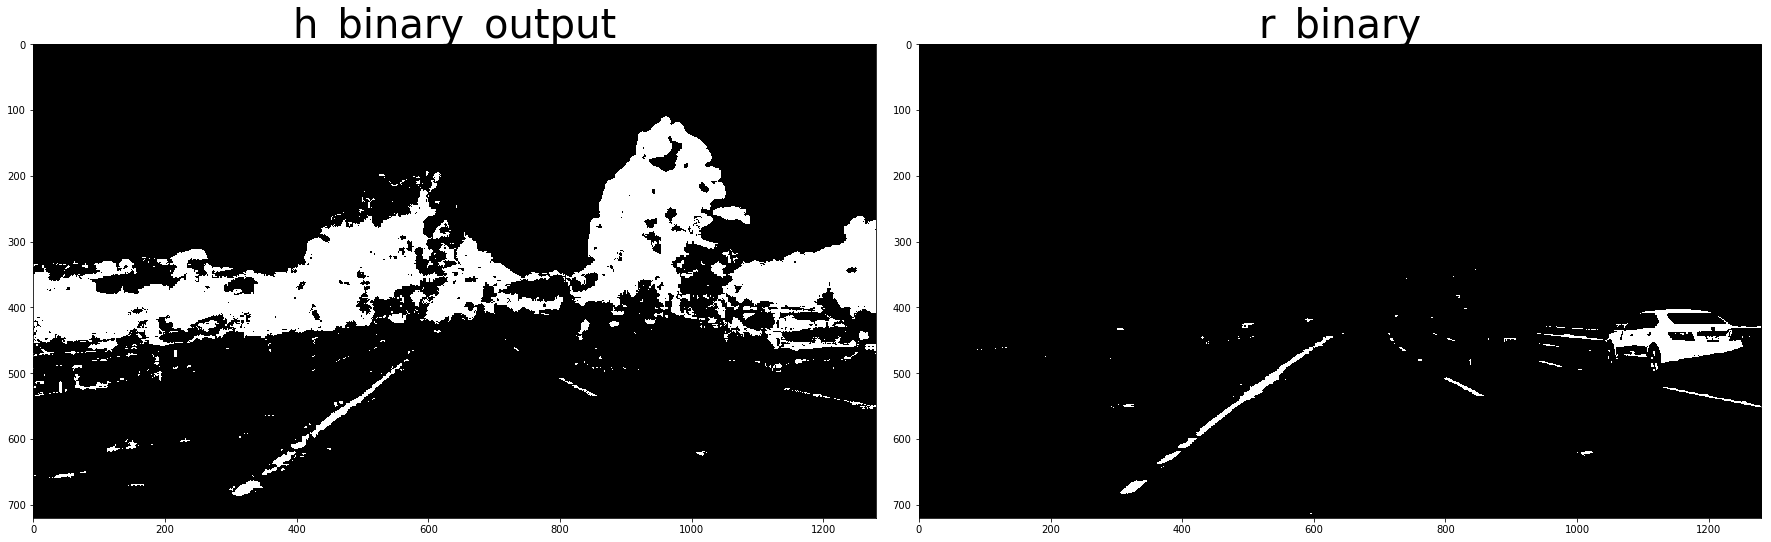

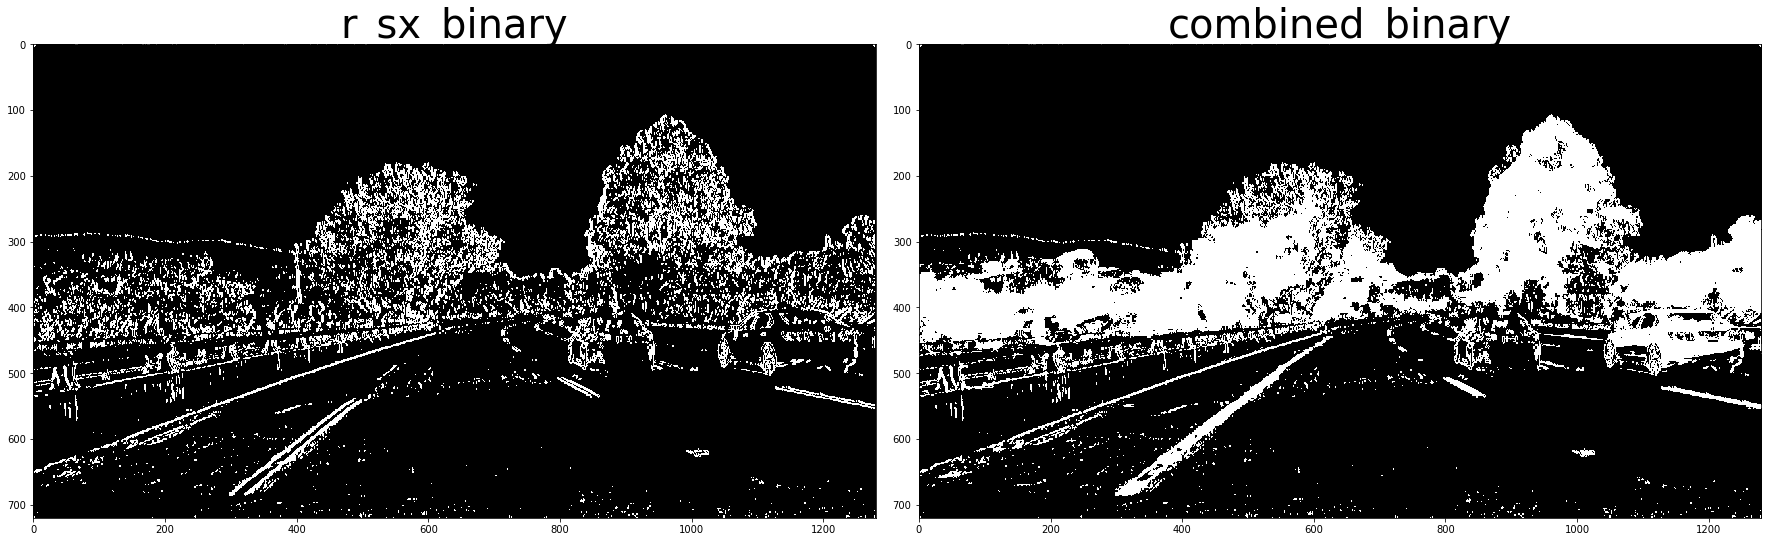

In [10]:
image = cv2.imread('test_images/test4.jpg')

show_color_gradient_pipline(image)

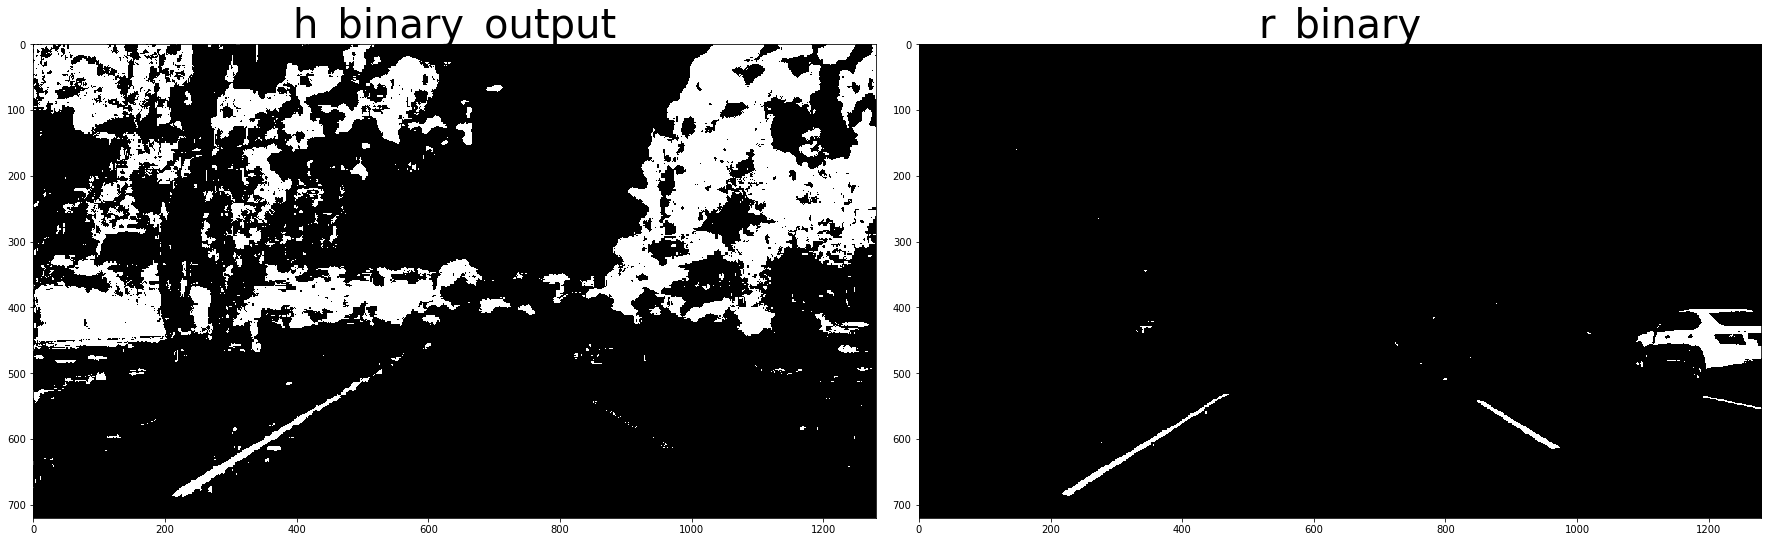

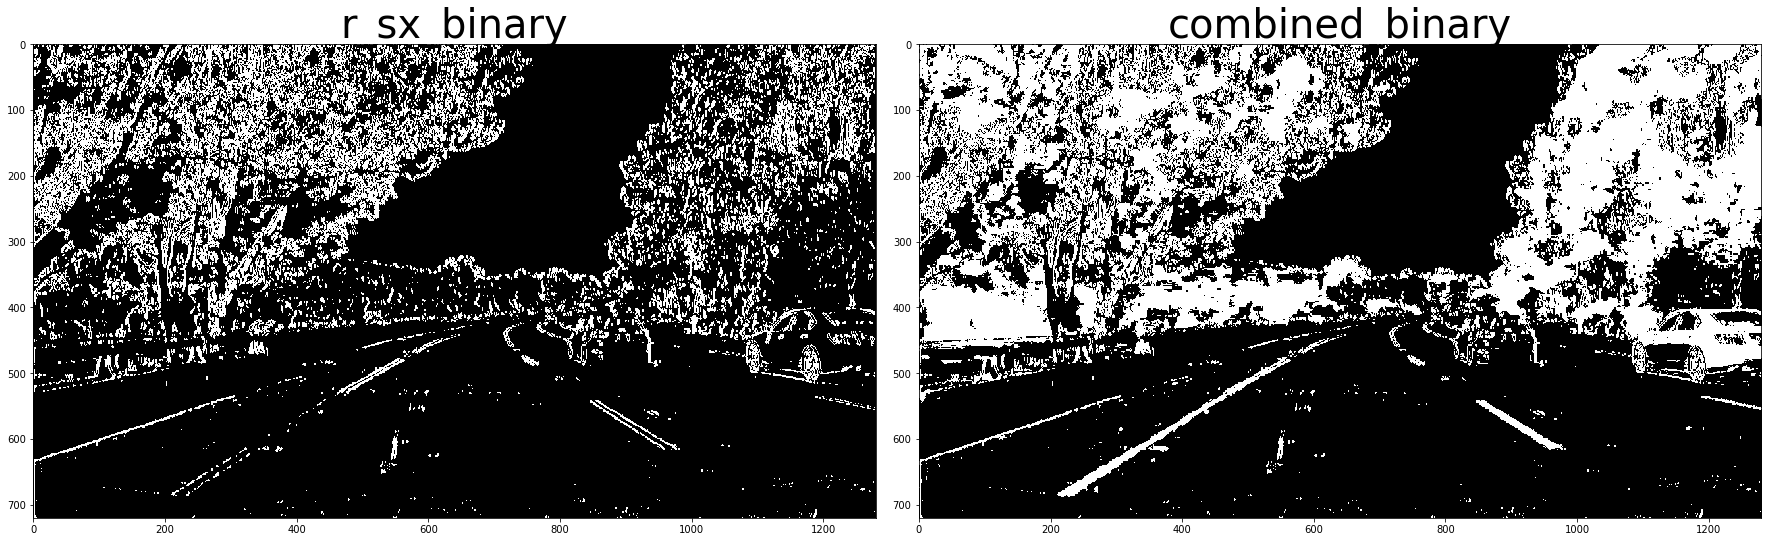

In [11]:
image = cv2.imread('test_images/test5.jpg')

show_color_gradient_pipline(image)

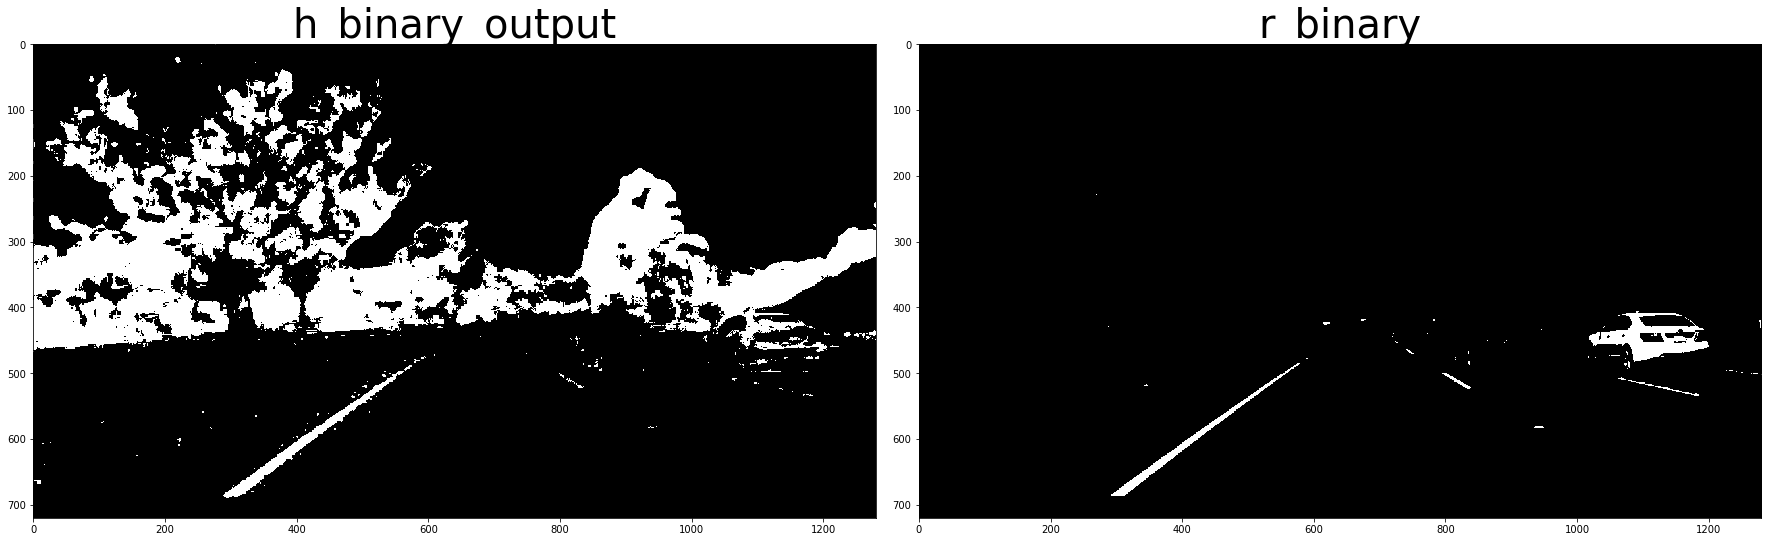

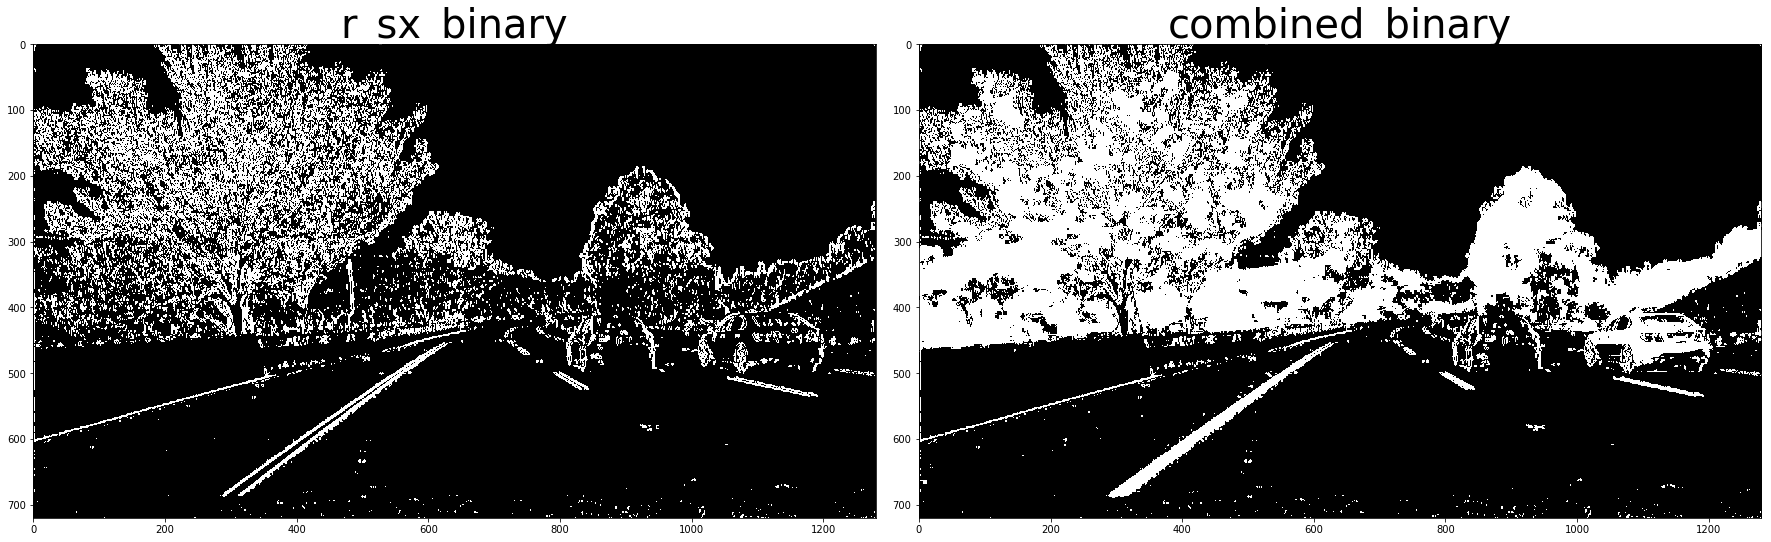

In [12]:
image = cv2.imread('test_images/test6.jpg')

show_color_gradient_pipline(image)

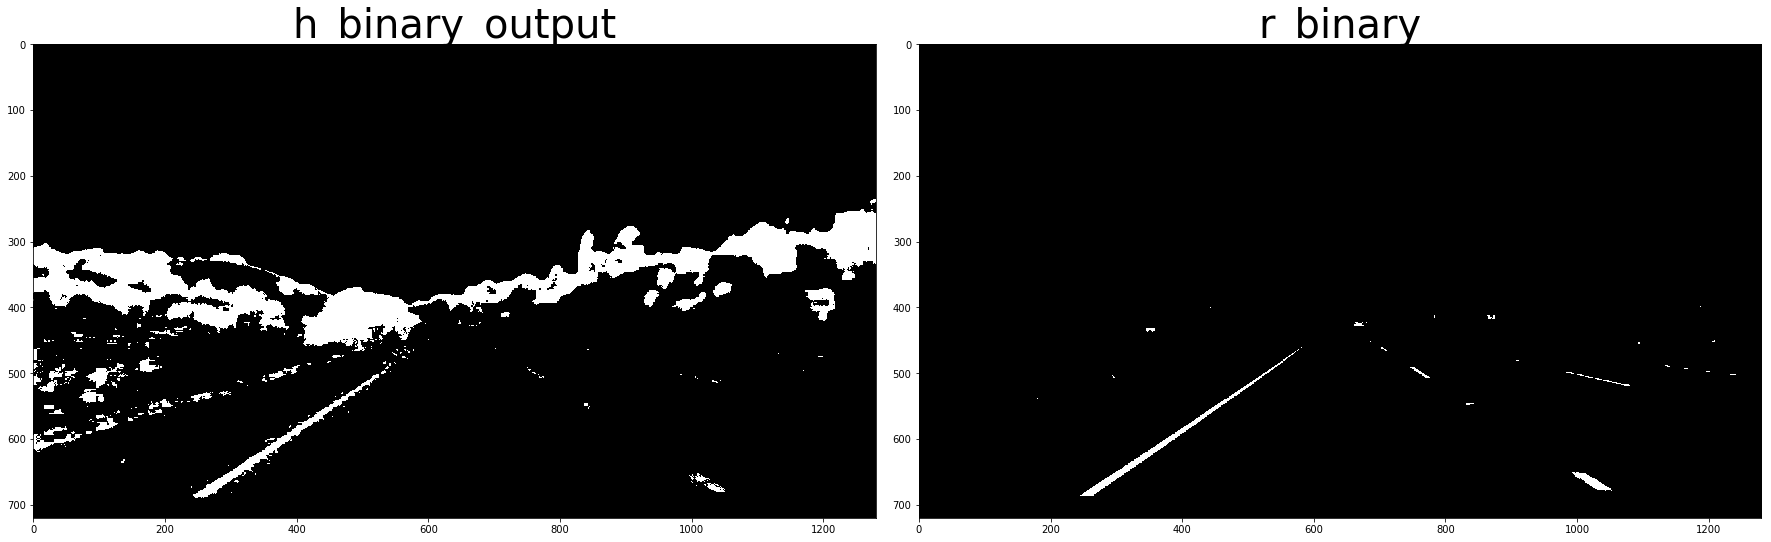

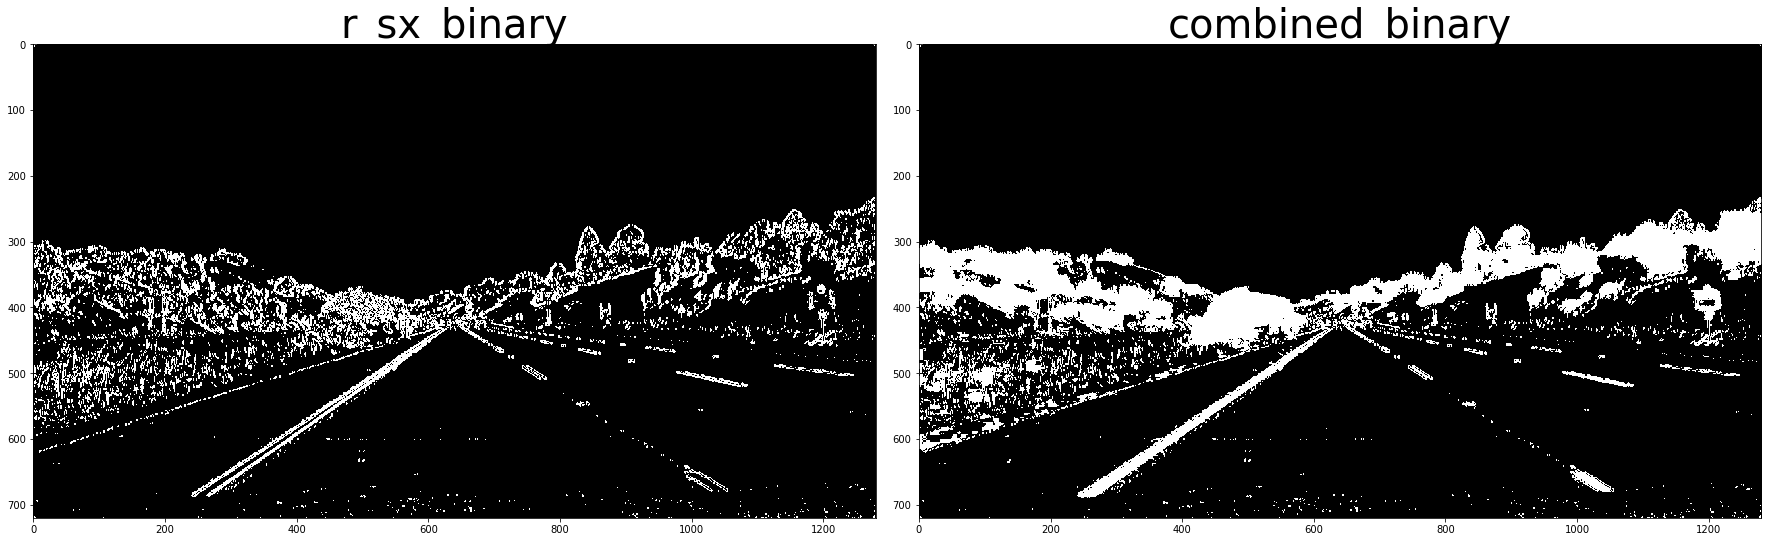

In [13]:
image = cv2.imread('test_images/straight_lines1.jpg')

show_color_gradient_pipline(image)

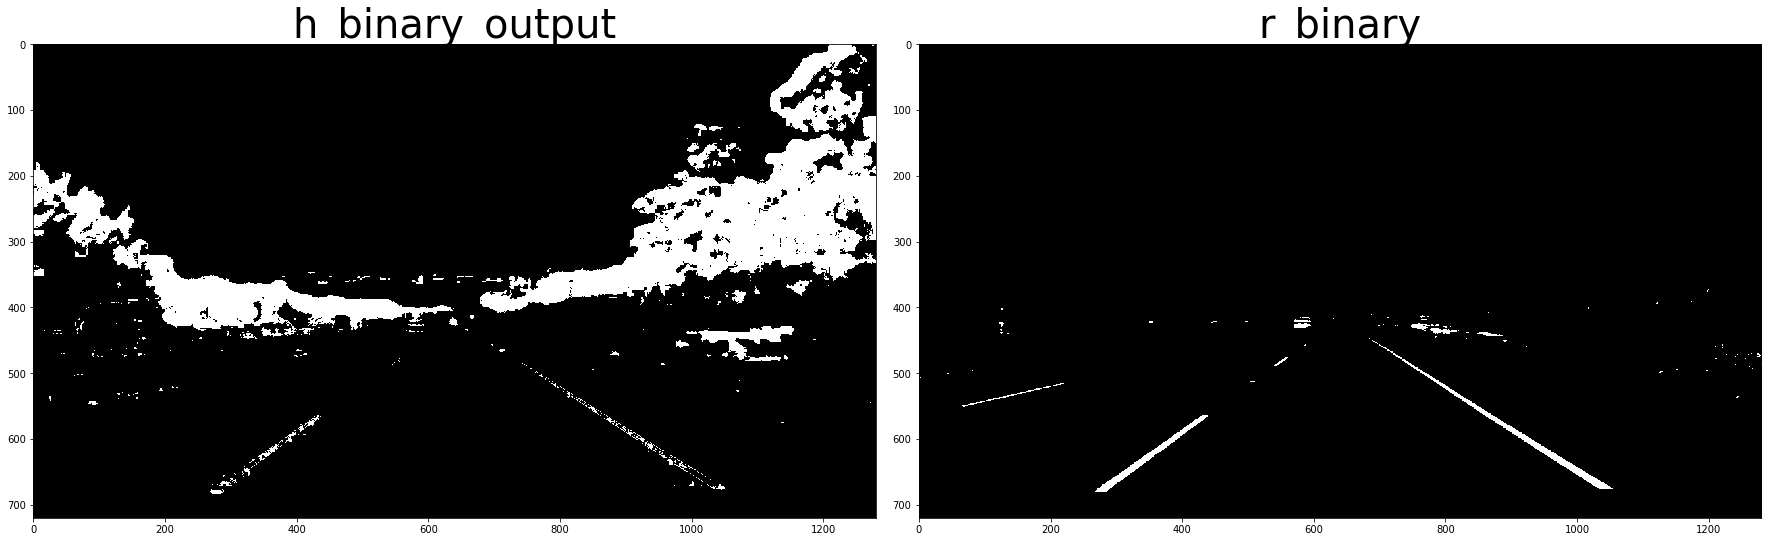

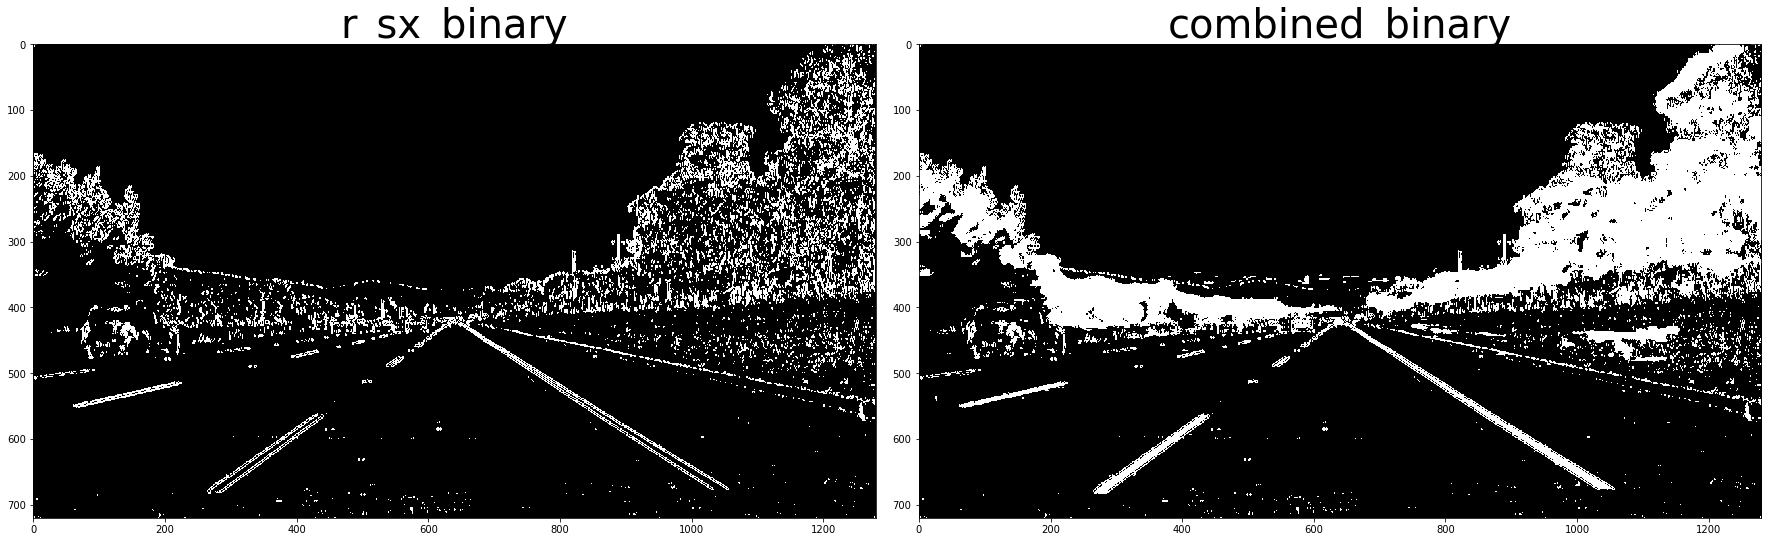

In [14]:
image = cv2.imread('test_images/straight_lines2.jpg')

show_color_gradient_pipline(image)

# Region of Interest

In [15]:
def region_of_inderest(img):
    imshape = img.shape

    vertices = np.array([[(150,imshape[0]),(imshape[1]//2-80, imshape[0]//2+80), 
                          (imshape[1]//2+80, imshape[0]//2+80), (imshape[1]-150,imshape[0])]], dtype=np.int32)

    masked_image = region_of_interest(img, vertices)
    
    return masked_image

In [16]:
def img_warp(img):
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])

    vertices = np.array([[(150,img_size[1]),(img_size[0]//2-50, img_size[1]//2+90), 
                          (img_size[0]//2+50, img_size[1]//2+90), (img_size[0]-150,img_size[1])]], dtype=np.int32)

    # show_region_of_interest(combined_binary, vertices[0])

    src = np.float32(vertices)
    
    dst = np.float32([[(300,img_size[1]), (300, 0), (img_size[0]-350,0), (img_size[0]-350,img_size[1])]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

In [17]:
def show_warped(img):
    combined_binary, h_binary_output, r_binary, r_sx_binary = color_gradient_pipline(image)
    
    masked_image = region_of_inderest(combined_binary)
    
    wraped_img = img_warp(masked_image)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(combined_binary, cmap='gray')
    ax1.set_title('combined_binary', fontsize=40)

    ax2.imshow(wraped_img, cmap='gray')
    ax2.set_title('wraped_img', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

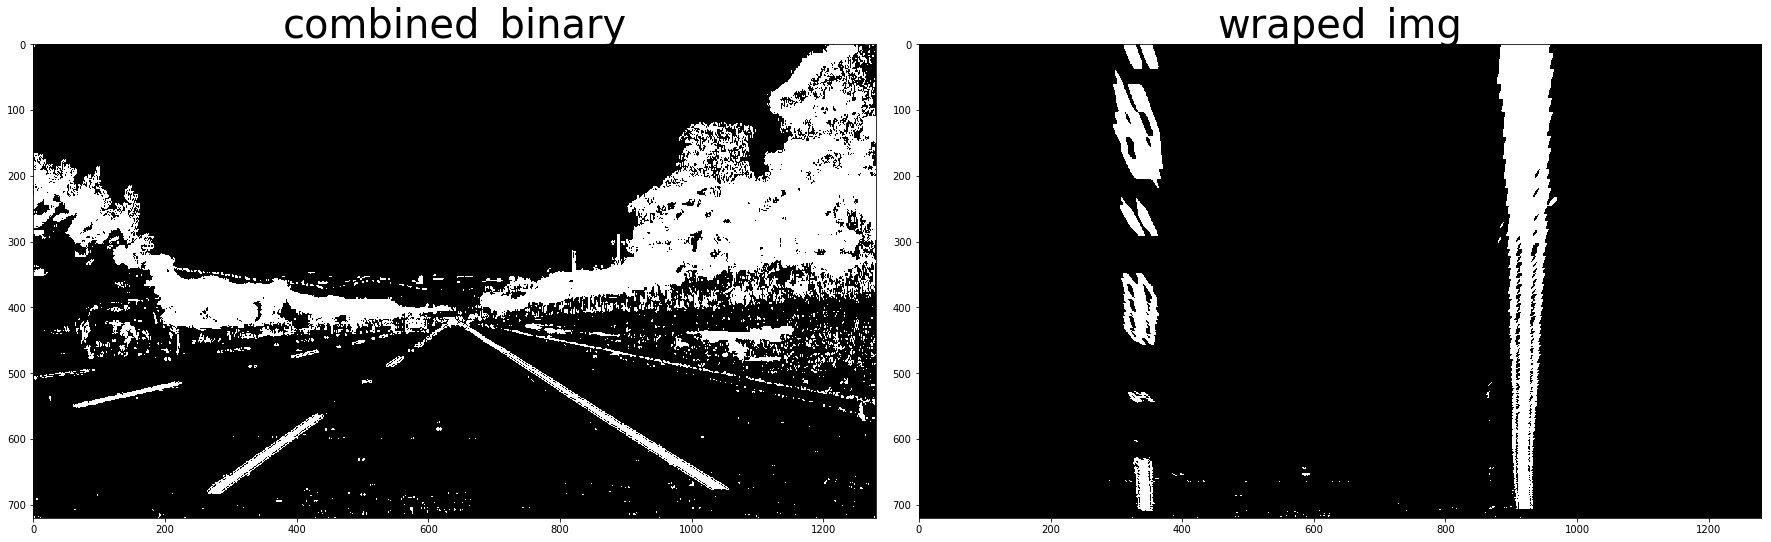

In [18]:
image = cv2.imread('test_images/straight_lines2.jpg')

show_warped(image)

# Finding the Lines